In [1]:
import numpy as np
from os import sys, path, environ
from os import sep, mkdir, walk
from os import chdir, environ, getcwd
import os as os
import sys
import string, random
from shutil import copy, copytree
#
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.tri import Triangulation
#
import netCDF4 as nc
from ot_chaos import *
import openturns as ot
import openturns.viewer as viewer
import scipy as scipy
#
colors=['#002d74', '#e85113', '#1fa12e', '#c9d200', '#f49e00', '#006ab3', '#3381ff', '#f2855a', '#54de64']

### Read the input timeseries from netcdf, and plot the sample

In [2]:
"""
The nc file is created using the notebook called "sample_uncertain_inputs.ipync"
"""
nc_file = nc.Dataset("windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc")
nc_file_var_names = [key for key in nc_file.variables.keys()] 
nc_file_var_dimensions = nc_file.variables[nc_file_var_names[2]].dimensions
nc_file_var_shape = nc_file.variables[nc_file_var_names[2]].shape
print("Variables are : ", nc_file_var_names) # get all variable names
print("Dimensions of variable "+nc_file_var_names[2]+" are : ", nc_file_var_dimensions) #get dimensions of var 1
print("Shape of variable "+nc_file_var_names[2]+" is : ", nc_file_var_shape) #get shape of var 1

#
nvar = 3
MC_sample = np.zeros((len(nc_file.variables["time"]),nvar))

#hub height timeseries
MC_sample[:,0] = nc_file.variables["direction"][:]
MC_sample[:,1] = nc_file.variables["speed"][:]
MC_sample[:,2] = nc_file.variables["z0"][:]

##profile timeseries 
#z_hub = 119.0
#for j in range(len(nc_file.variables["time"])):
#    MC_sample[j,0] = np.interp(z_hub, nc_file.variables["z"][:], nc_file.variables["direction"][j,:])
#    MC_sample[j,1] = np.interp(z_hub, nc_file.variables["z"][:], nc_file.variables["speed"][j,:])
#MC_sample[:,2] = nc_file.variables["z0"][:]

uq_varnames = ["direction", "speed","z0"]
uq_var_marginals = ["normal", "normal", "uniform"]
#uq_var_marginals = ["kernel", "kernel", "kernel"]

Variables are :  ['time', 'direction', 'speed', 'z0', 'TI', 'ustar']
Dimensions of variable speed are :  ('time',)
Shape of variable speed is :  (1000,)


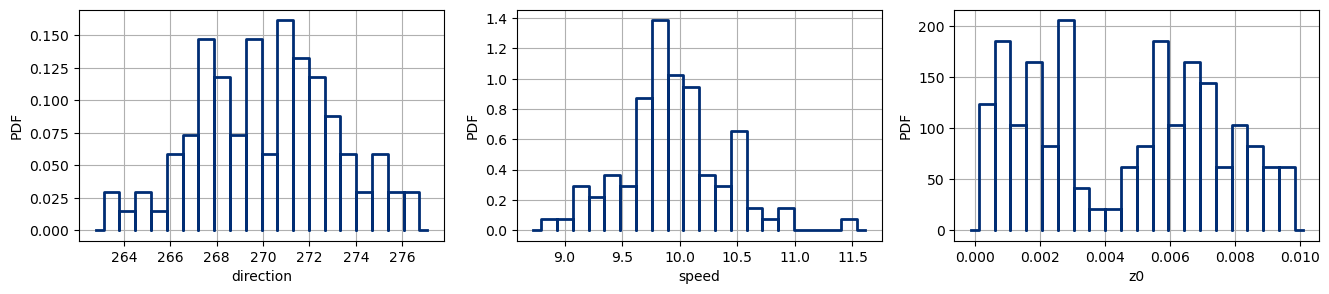

In [3]:
# plot and compare to histogram
MC_sample_size = 100
histograms = [] 
graphs = []
for j in range(MC_sample.shape[1]):
    sample = ot.Sample([[i] for i in MC_sample[:MC_sample_size,j]])
    histograms.append(ot.HistogramFactory().buildAsHistogram(sample, 20))
    graphs.append(histograms[j].drawPDF())
    graphs[j].setColors(colors)
    graphs[j].setXTitle(uq_varnames[j])
    graphs[j].setYTitle("PDF")
    graphs[j].setLegends([""])#[uq_varnames[j]])
    graphs[j].setTitle("")
#
fig = plt.figure(figsize=(16, 3))
axs = []
for j in range(MC_sample.shape[1]):
    axs.append(fig.add_subplot(1, MC_sample.shape[1], j+1))
    _ = viewer.View(graphs[j], figure=fig, axes=[axs[j]])

### Read the results from the different tools

In [55]:
#code_saturne
code_saturne_power_table  = np.genfromtxt("flow_tools_results/windio_toy/MC_hub_timeseries_power_cpstar_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
number_of_turbines = code_saturne_power_table.shape[1]

#pywake
import xarray as xr
pywake_power_data = xr.load_dataset('pywake_hh_results/PowerTable.nc')
pywake_power_table = np.zeros((MC_sample_size, number_of_turbines))
for j in range(number_of_turbines):
    pywake_power_table[:,j] = pywake_power_data['Power'].sel(wt=j).values[:MC_sample_size]

#foxes
foxes_power_table = np.genfromtxt("foxes_results/windio_toy/power_windio_toy_foxes_A.csv", delimiter=',', skip_header=1)[:,1:]

#wayves
wayves_power_table = np.zeros((MC_sample_size, number_of_turbines))

### Power distributions with the different tools

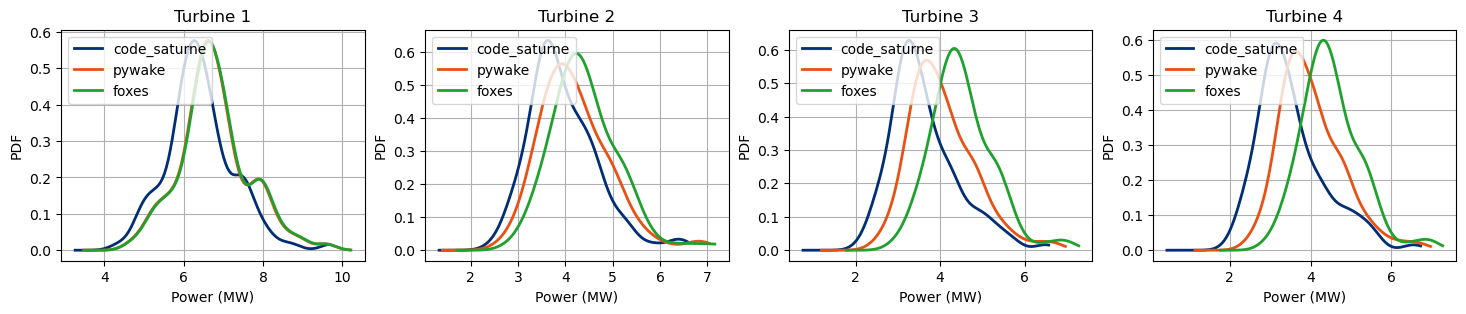

In [56]:
# read data

#power_histograms = []
code_saturne_power_KDE = []
pywake_power_KDE = []
foxes_power_KDE = []
wayves_power_KDE = []
#
power_graphs = []
kernel = ot.KernelSmoothing(ot.Normal())
for j in range(number_of_turbines):
    code_saturne_power_sample = ot.Sample([[i/10**6] for i in code_saturne_power_table[:,j]])
    pywake_power_sample = ot.Sample([[i/10**6] for i in pywake_power_table[:,j]])
    foxes_power_sample = ot.Sample([[i/10**6] for i in foxes_power_table[:,j]])
    #wayves_power_sample = ot.Sample([[i/10**6] for i in wayves_power_table[:,j]])
    
    # plot and compare to histogram
    #power_histograms.append(ot.HistogramFactory().buildAsHistogram(code_saturne_power_sample, 20))
    #power_graphs.append(power_histograms[j].drawPDF())
    
    #plot and compare empirical distributions
    code_saturne_power_KDE.append(kernel.build(code_saturne_power_sample))
    pywake_power_KDE.append(kernel.build(pywake_power_sample))
    foxes_power_KDE.append(kernel.build(foxes_power_sample))
    #wayves_power_KDE.append(kernel.build(wayves_power_sample))    
    
    #
    power_graphs.append(code_saturne_power_KDE[j].drawPDF())
    power_graphs[j].add(pywake_power_KDE[j].drawPDF())
    power_graphs[j].add(foxes_power_KDE[j].drawPDF())
    #power_graphs[j].add(wayves_power_KDE[j].drawPDF())
    #
    power_graphs[j].setColors(colors)
    power_graphs[j].setXTitle("Power (MW)")
    power_graphs[j].setYTitle("PDF")
    power_graphs[j].setTitle("")
    
    power_graphs[j].setLegends(["code_saturne", "pywake", "foxes"])#, "wayves"])

fig = plt.figure(figsize=(18, 3))
axs = []
for j in range(number_of_turbines):
    axs.append(fig.add_subplot(1, number_of_turbines, j+1))
    axs[j].set_title("Turbine "+str(j+1))
    _ = viewer.View(power_graphs[j], figure=fig, axes=[axs[j]])
    axs[j].legend(loc='upper left', ncol=1)
plt.show()

### Scatter plot example

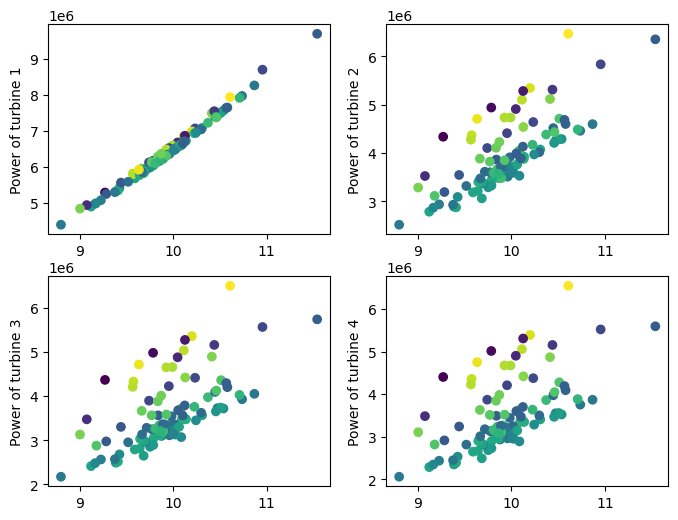

In [58]:
power_table = code_saturne_power_table
MC_direction = MC_sample[:MC_sample_size,0]
MC_speed = MC_sample[:MC_sample_size,1]
MC_z0 = MC_sample[:MC_sample_size,2]

fig,ax = plt.subplots(2,2,figsize=(8,6))
dependency_var = MC_speed
color_var = MC_direction
ax[0,0].scatter(dependency_var, power_table[:,0], c=color_var, label='test')
ax[0,0].set_ylabel('Power of turbine 1')
ax[0,1].scatter(dependency_var, power_table[:,1], c=color_var)
ax[0,1].set_ylabel('Power of turbine 2')
ax[1,0].scatter(dependency_var, power_table[:,2], c=color_var)
ax[1,0].set_ylabel('Power of turbine 3')
ax[1,1].scatter(dependency_var, power_table[:,3], c=color_var)
ax[1,1].set_ylabel('Power of turbine 4')
plt.show()

## Sensitivity Analysis (SA)

### Sobol indices of power using Polynomial Chaos expansion (PCE)

In [59]:
input_variable_array = MC_sample[:MC_sample_size,:]
    
def plot_power_sobols(power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = 3):
    power_sobol_indices = np.zeros((power_table.shape[1],nvar))
    power_total_sobol_indices = np.zeros((power_table.shape[1],nvar))
    sample_std = np.std(power_table,axis=0)
    compute_power_sobols = True
    #Show polynomials
    if(compute_power_sobols):
        copula_type = "independent"  #choices: gaussian, independent
        for i in range(number_of_turbines):
            if(sample_std[i]!=0):        
                fullSet = StatisticalSet(input_variable_array[:,:],power_table[:,i])
                training_size = fullSet.setSize
                test_size = 0
                otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                        test_size=test_size, prediction_size=0, number_of_sets=1)
                otChaosObject.marginals = []

                for v in range(fullSet.inputDimension):
                    otChaosObject.marginals.append(uq_var_marginals[v])
                    otChaosObject.copula = copula_type

                otChaosObject.polynomialDegree= PC_deg
                otChaosObject.construct_PCE_ot()
                chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
                for v in range(fullSet.inputDimension):
                    power_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                    power_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  


    fig,ax = plt.subplots(1,number_of_turbines,figsize=(16,3))
    # Bar positions
    bar_width=0.24
    items = uq_varnames
    bar_positions1 = np.arange(len(items))
    bar_positions2 = bar_positions1 + bar_width
    bar_positions3 = bar_positions2 + bar_width

    for i in range(number_of_turbines):
        values1 = [] ; values2 = [] ; values3 = []
        for j in range(nvar):      
            values1.append(power_sobol_indices[i,j])
            values2.append(power_total_sobol_indices[i,j])
            values3.append(power_total_sobol_indices[i,j]-power_sobol_indices[i,j])
        # Create bar plots
        ax[i].bar(bar_positions1, values1, width=bar_width, label='1st sobols', color='blue')
        ax[i].bar(bar_positions2, values2, width=bar_width, label='Total sobols', color='orange')
        ax[i].bar(bar_positions3, values3, width=bar_width, label='Interaction', color='red')

        # Set labels and title
        ax[i].set_xlabel('Variables')
        ax[i].set_ylabel('Sobols')
        # Set x-axis ticks and labels
        ax[i].set_xticks(bar_positions2)
        ax[i].set_xticklabels(items)
        ax[i].set_title("Turbine " + str(i+1))
        if(i==0):
            ax[i].legend(loc="best")

    # Show the plot
    plt.show()

#### code_saturne

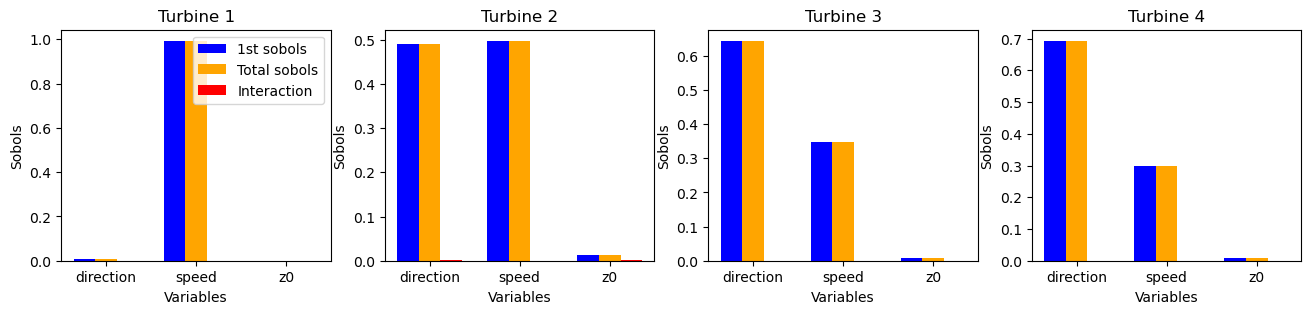

In [60]:
plot_power_sobols(code_saturne_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = 2)

#### pywake

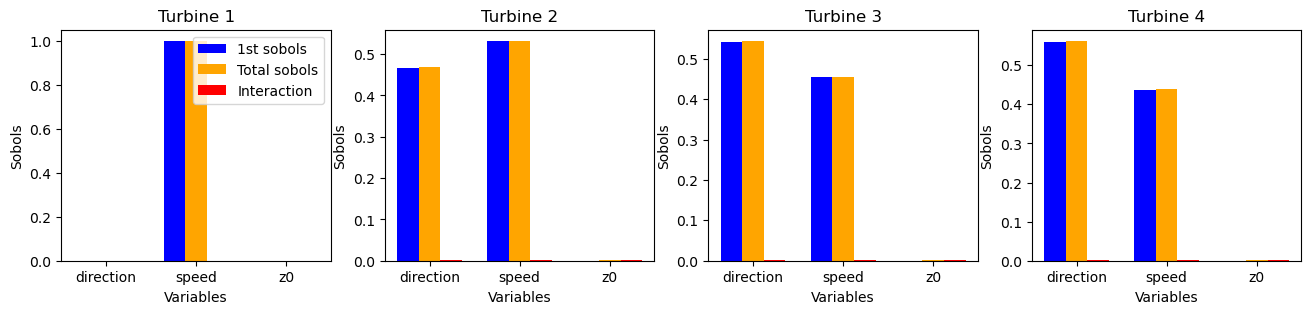

In [61]:
plot_power_sobols(pywake_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = 2)

#### foxes

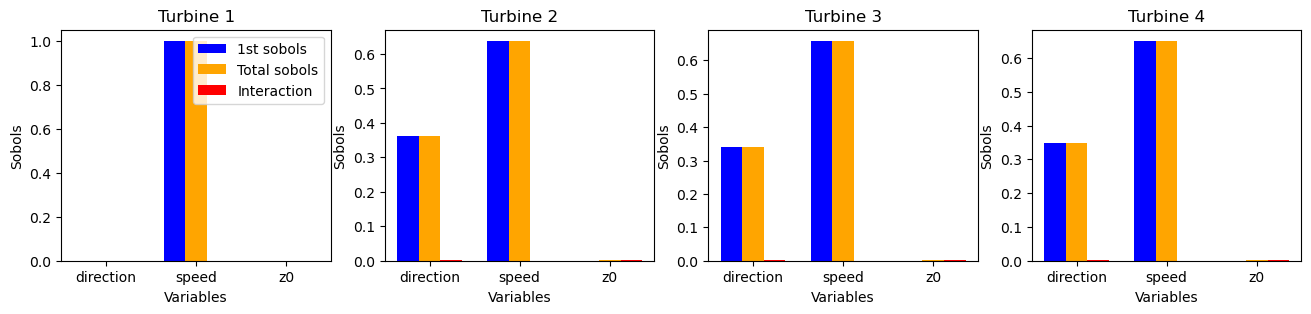

In [62]:
plot_power_sobols(foxes_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = 2)

### Sobol indices of velocity using Polynomial Chaos expansion (PCE)

In [64]:
code_saturne_flow = nc.Dataset('flow_tools_results/windio_toy/MC_hub_timeseries_velocity_code_saturne.nc')

#get triangulation
triangles = code_saturne_flow.variables['triangle_vertices_ids'][:].astype(int)
npoints = len(triangles)
x_tri = code_saturne_flow.variables['vertices_x_coords'][:] ; x = np.zeros((npoints))
y_tri = code_saturne_flow.variables['vertices_y_coords'][:] ; y = np.zeros((npoints)) 
for j in range(npoints):
    i1, i2, i3 = triangles[j]
    x[j] = (x_tri[i1] + x_tri[i2] + x_tri[i3])/3.
    y[j] = (y_tri[i1] + y_tri[i2] + y_tri[i3])/3.
    
#get flow variables
code_saturne_velocity_magnitude = np.zeros((npoints,MC_sample_size))
for j in range(MC_sample_size):
    code_saturne_velocity_magnitude[:,j] = np.sqrt(code_saturne_flow.variables['u'][:,j]**2 + \
                                                   code_saturne_flow.variables['v'][:,j]**2 +  \
                                                   code_saturne_flow.variables['w'][:,j]**2) 

In [65]:
def plot_profile_var_sobols(profile_coordinates, profile_speed, input_variable_array, uq_var_marginals, PC_deg = 3):
    profile_sobol_indices = np.zeros((len(profile_coordinates), nvar))
    profile_total_sobol_indices = np.zeros((len(profile_coordinates),nvar))
    sample_std = np.std(profile_speed,axis=1)
    sample_mean = np.mean(profile_speed,axis=1)
    compute_power_sobols = True
    #Show polynomials
    if(compute_power_sobols):
        copula_type = "independent"  #choices: gaussian, independent
        for i in range(len(profile_coordinates)):
            if(sample_std[i]!=0):        
                fullSet = StatisticalSet(input_variable_array[:,:],profile_speed[i,:])
                training_size = fullSet.setSize
                test_size = 0
                otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                        test_size=test_size, prediction_size=0, number_of_sets=1)
                otChaosObject.marginals = []

                for v in range(fullSet.inputDimension):
                    otChaosObject.marginals.append(uq_var_marginals[v])
                    otChaosObject.copula = copula_type

                otChaosObject.polynomialDegree= PC_deg
                otChaosObject.construct_PCE_ot()
                chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
                for v in range(fullSet.inputDimension):
                    profile_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                    profile_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  


    fig,ax = plt.subplots(4,1,figsize=(10,8))    
    ax[0].plot(profile_coordinates, sample_mean, 'g-', label='mean')
    ax[0].plot(profile_coordinates, profile_speed[:,5], 'b--', label='Member 6')
    ax[1].plot(profile_coordinates, sample_std, 'r-', label='std')
    for v in range(nvar):
        ax[2].plot(profile_coordinates, profile_sobol_indices[:,v], color=colors[v], label=uq_varnames[v])
        ax[2].set_ylabel("First Sobol indices")
    for v in range(nvar):
        ax[3].plot(profile_coordinates, profile_total_sobol_indices[:,v]-profile_sobol_indices[:,v], color=colors[v], label=uq_varnames[v])
        ax[3].set_ylabel("Interaction Sobol indices")
        ax[3].set_xlabel("X coordinates")
    
    return fig, ax

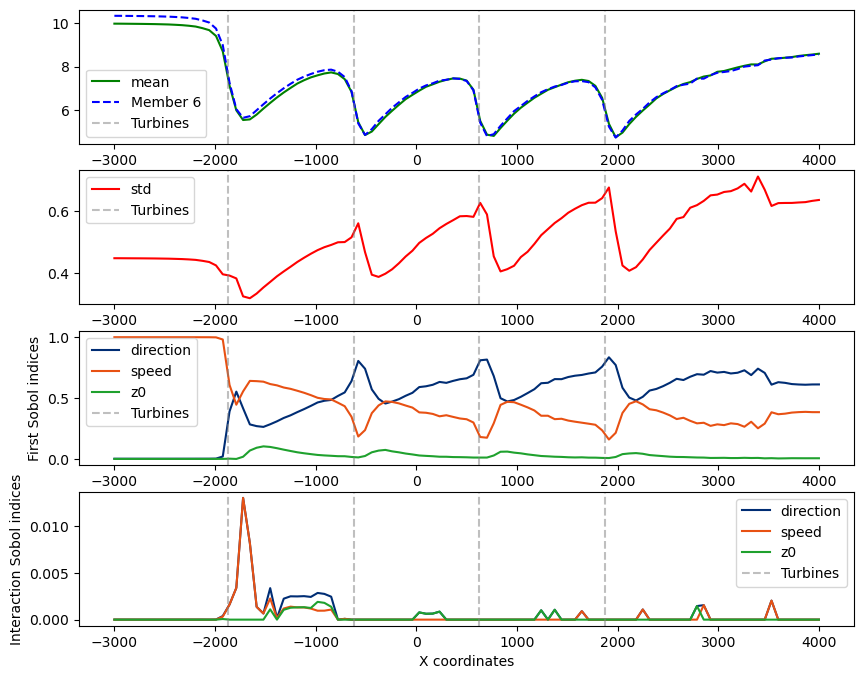

In [66]:
#Points center_line
p1 = np.array([-3000,0]) ; p2 = np.array([4000,0]) ; npts = 105
center_line_coords = p1.reshape(1, -1)+np.arange(npts).reshape(-1, 1)/float(npts-1)*(p2-p1).reshape(1, -1)
center_line_speed = np.zeros((npts, MC_sample_size))

nearest_x = [] ; nearest_y = [] ; nearest_ids = []
for j in range(code_saturne_velocity_magnitude.shape[0]):
    if(np.abs(y[j]-0.0)<100.0):
        nearest_x.append(x[j])
        nearest_y.append(y[j])
        nearest_ids.append(j)

nearest_zone_speeds = np.zeros((len(nearest_x),MC_sample_size))
for i in range(MC_sample_size):
    nearest_zone_speeds[:,i] = code_saturne_velocity_magnitude[nearest_ids,i]
    center_line_speed[:,i] = scipy.interpolate.griddata((nearest_x, nearest_y), nearest_zone_speeds[:,i], \
                                                        (center_line_coords[:,0], center_line_coords[:,1]), \
                                                        method='linear')
    
fig, ax = plot_profile_var_sobols(center_line_coords[:,0], center_line_speed, input_variable_array, uq_var_marginals, PC_deg = 3)
# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])-1872.15
turbine_labels = ["Turbines", None,None,None]
for i in range(4):
    for j in range(number_of_turbines):
        ax[i].axvline(x=turbine_x_positions[j], color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
    ax[i].legend()
plt.show()

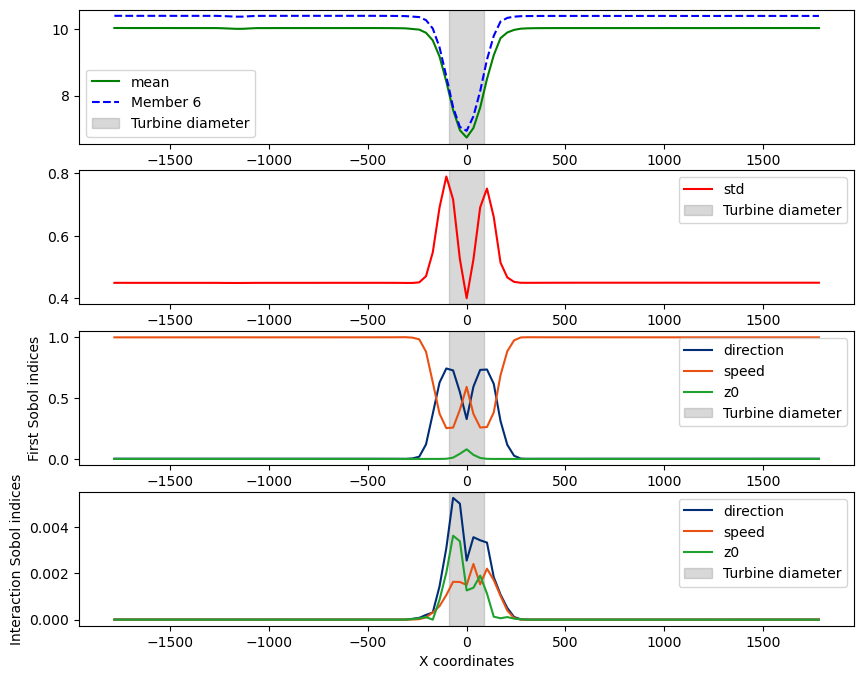

In [67]:
#Points cross_line
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3]) - 1872.15
turbine_diameter = 178.3
p1 = np.array([turbine_x_positions[0] + 3*turbine_diameter ,0-10*turbine_diameter]) ; p2 = np.array([turbine_x_positions[0] + 3*turbine_diameter,0+10*turbine_diameter]) ; npts = 105
cross_line_coords = p1.reshape(1, -1)+np.arange(npts).reshape(-1, 1)/float(npts-1)*(p2-p1).reshape(1, -1)
cross_line_speed = np.zeros((npts, MC_sample_size))

nearest_x = [] ; nearest_y = [] ; nearest_ids = []
for j in range(code_saturne_velocity_magnitude.shape[0]):
    if(np.abs(x[j]-(turbine_x_positions[0] + 3*turbine_diameter))<100.0):
        nearest_x.append(x[j])
        nearest_y.append(y[j])
        nearest_ids.append(j)

nearest_zone_speeds = np.zeros((len(nearest_x),MC_sample_size))
for i in range(MC_sample_size):
    nearest_zone_speeds[:,i] = code_saturne_velocity_magnitude[nearest_ids,i]
    cross_line_speed[:,i] = scipy.interpolate.griddata((nearest_x, nearest_y), nearest_zone_speeds[:,i], \
                                                        (cross_line_coords[:,0], cross_line_coords[:,1]), \
                                                        method='linear')

fig, ax = plot_profile_var_sobols(cross_line_coords[:,1], cross_line_speed, input_variable_array, uq_var_marginals, PC_deg = 3)
for i in range(4):
    ax[i].axvspan(xmin=-0.5*turbine_diameter, xmax=0.5*turbine_diameter, \
                  color='grey',alpha=0.3, label="Turbine diameter")
    ax[i].legend()
plt.show()